# Data Loading

Having a good understanding of your input data is critical to designing strategies that maximises your analysis sensivitity. Typically, an analysis will start with Derived Analysis Object Data (DAOD) for the targeted final states as a precursor to all analysis inputs. 

The DAODs will then be further processed into (mini) NTuples by applying analysis-specific preselections, object ID, isolation and calibration. During this procedure, various efficiency scale factors and corrections to the event weights and kinematics will be applied. A final set of kinematic variables will also be computed. For the Run 3 $ttH$ analysis, this step is done by the HGamCore framework and the resulting NTuples are called MxAODs. 

Notice that up to the ntuples step, the inputs are in the form of **ROOT** files, which are not the ideal data format for modern data analysis especially when machine learning is involved. Therefore, NTuples are usually further converted into formats that can be efficiently streamed into numpy arrays that are supported by most data analysis (numpy, pandas, scipy, ...) and machine learning libraries (XGBoost, tensorflow keras, pytorch, ...).

<div style="text-align: center;">
    <img src='../../resources/figures/data_formats.png' width='800' class="center">
</div>

## Reading a ROOT File

The ROOT data format is notoriously known to be difficult to view and manipulate as the data is not streamed in a columnar manner, i.e. you will need to iterate event-by-event in an event loop to read the whole column. Fortunately, modern tools like [awkward array](https://awkward-array.org/doc/main/) and [RDataFrames](https://root.cern/doc/master/classROOT_1_1RDataFrame.html) (which is part of ROOT software) can help with this greatly.

Let's test it on some example ntuples from easyjet.

In [1]:
import os
import glob

#directory containing ttH 
mxaod_basedir="/eos/atlas/atlascerngroupdisk/phys-higgs/HSG1/MxAOD/h028/"

mc16a_folder = "mc16a/Nominal/mc16a.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r9364_p4180_h028.root/"
mc16d_folder = "mc16d/Nominal/mc16d.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10201_p4180_h028.root/"
mc16e_folder = "mc16e/Nominal/mc16e.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10724_p4180_h028.root/"

def get_file_list(basedir, folder, file):
    return glob.glob(os.path.join(basedir, folder, file))

# name of ttH files and reference key mc16a
sample_files = {
    "ttH": {
        "test_file" : get_file_list(mxaod_basedir, mc16e_folder, "*001*")[0]
# Commenting out reading all files, this is not needed yet for initial exploration of the data
#         "mc16a" : get_file_list(mxaod_basedir, mc16a_folder, "*"),
#         "mc16d" : get_file_list(mxaod_basedir, mc16d_folder, "*"),
#         "mc16e" : get_file_list(mxaod_basedir, mc16e_folder, "*")
     }   
}

import pprint # pretty print for dictionary objects
pprint.pprint(sample_files)

#Name of tree you want to access
treename = "CollectionTree"

{'ttH': {'test_file': '/eos/atlas/atlascerngroupdisk/phys-higgs/HSG1/MxAOD/h028/mc16e/Nominal/mc16e.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10724_p4180_h028.root/mc16e.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10724_p4180_h028.001.root'}}


### Option 1 - Using uproot (high-level interface of awkward array)

In [2]:
import uproot
import awkward as ak
filename = os.path.join(mxaod_basedir, sample_files["ttH"]["test_file"])
f = uproot.open(filename)
f

<ReadOnlyDirectory '/' at 0x7fab90995cd0>

With uproot, you can browse content of the root file just like browsing directories. To list the contents of the root file:

In [3]:
f.keys()

['CollectionTree;1',
 'CutFlow_PowhegPy8_ttH125_fixweight;1',
 'CutFlow_PowhegPy8_ttH125_fixweight_noDalitz;1',
 'CutFlow_PowhegPy8_ttH125_fixweight_weighted;1',
 'CutFlow_PowhegPy8_ttH125_fixweight_noDalitz_weighted;1',
 'MetaData;1']

Now, traverse into the main tree of the root file, you will see all the available branches of the tree

In [4]:
t = f[treename]
t.keys()

['HGamPhotons',
 'HGamPhotonsAux.',
 'HGamPhotonsAuxDyn.DeltaE',
 'HGamPhotonsAuxDyn.Eratio',
 'HGamPhotonsAuxDyn.Rconv',
 'HGamPhotonsAuxDyn.Reta',
 'HGamPhotonsAuxDyn.Rhad',
 'HGamPhotonsAuxDyn.Rhad1',
 'HGamPhotonsAuxDyn.Rphi',
 'HGamPhotonsAuxDyn.author',
 'HGamPhotonsAuxDyn.cl_E',
 'HGamPhotonsAuxDyn.cl_E_TileGap3',
 'HGamPhotonsAuxDyn.cl_Es0',
 'HGamPhotonsAuxDyn.cl_Es1',
 'HGamPhotonsAuxDyn.cl_Es2',
 'HGamPhotonsAuxDyn.cl_Es3',
 'HGamPhotonsAuxDyn.cl_eta',
 'HGamPhotonsAuxDyn.cl_etaCalo',
 'HGamPhotonsAuxDyn.cl_phiCalo',
 'HGamPhotonsAuxDyn.cl_ratioEs1Es2',
 'HGamPhotonsAuxDyn.conversionType',
 'HGamPhotonsAuxDyn.convtrk1nPixHits',
 'HGamPhotonsAuxDyn.convtrk1nSCTHits',
 'HGamPhotonsAuxDyn.convtrk2nPixHits',
 'HGamPhotonsAuxDyn.convtrk2nSCTHits',
 'HGamPhotonsAuxDyn.e277',
 'HGamPhotonsAuxDyn.eta',
 'HGamPhotonsAuxDyn.eta_s1',
 'HGamPhotonsAuxDyn.eta_s2',
 'HGamPhotonsAuxDyn.f1',
 'HGamPhotonsAuxDyn.fracs1',
 'HGamPhotonsAuxDyn.isEMTight',
 'HGamPhotonsAuxDyn.isEMTight_nofudge',

### Using quickstats helper method

quickstats also offer helper methods for inter-conversions between root and numpy/dataframe formats 

In [5]:
from quickstats.utils.data_conversion import root2array, root2dataframe

In [6]:
# Include whatever branches you want to look at
columns = ['HGamTruthEventInfoAuxDyn.pT_y1','HGamTruthEventInfoAuxDyn.pT_y2','HGamEventInfoAuxDyn.m_yy','HGamEventInfoAuxDyn.N_lep','HGamTruthPhotonsAuxDyn.truthOrigin']

In [7]:
# here library means which backend to use for the conversion
# choose between 'root' (RDataFrame) and 'uproot'
# usually uproot is a little faster but offers less functionality
# by default RDataFrame conversion uses multi-threading so the
# order of events is not preserved
array = root2array(filename, treename=treename, columns=columns,
                   library='uproot')
array

{'HGamTruthEventInfoAuxDyn.pT_y1': array([ 93556.1 , 137769.02, 124778.41, ..., 199326.62,  95862.84,
        150685.69], dtype=float32),
 'HGamTruthEventInfoAuxDyn.pT_y2': array([ 51830.66 , 121490.336,  84612.79 , ..., 191318.9  ,  31050.13 ,
          9117.433], dtype=float32),
 'HGamEventInfoAuxDyn.m_yy': array([-9.9000000e+01,  1.2535517e+05,  2.6351759e+05, ...,
         1.2549244e+05, -9.9000000e+01, -9.9000000e+01], dtype=float32),
 'HGamEventInfoAuxDyn.N_lep': array([0, 0, 1, ..., 1, 0, 0], dtype=int32),
 'HGamTruthPhotonsAuxDyn.truthOrigin': array([array([14, 14], dtype=int32), array([14, 14, 37], dtype=int32),
        array([14, 14], dtype=int32), ...,
        array([14, 37, 14], dtype=int32),
        array([14, 14, 40, 40, 37], dtype=int32),
        array([14, 14], dtype=int32)], dtype=object)}

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(array)
df

,HGamTruthEventInfoAuxDyn.pT_y1,HGamTruthEventInfoAuxDyn.pT_y2,HGamEventInfoAuxDyn.m_yy,HGamEventInfoAuxDyn.N_lep,HGamTruthPhotonsAuxDyn.truthOrigin
0,93556.101562,51830.660156,-99.000000,0,"[14, 14]"
1,137769.015625,121490.335938,125355.171875,0,"[14, 14, 37]"
2,124778.406250,84612.789062,263517.593750,1,"[14, 14]"
3,69191.976562,52902.628906,127133.351562,0,"[14, 14]"
4,207734.765625,73198.046875,123441.046875,0,"[14, 14, 37]"
...,...,...,...,...,...
119995,116954.179688,28414.496094,-99.000000,0,"[14, 14]"
119996,56583.253906,22706.156250,153090.515625,1,"[14, 14]"
119997,199326.625000,191318.906250,125492.437500,1,"[14, 37, 14]"
119998,95862.843750,31050.130859,-99.000000,0,"[14, 14, 40, 40, 37]"


## Visualizing Kinematic Distributions

To make plots of 1D histograms of kinematic distributions, you may use `VariableDistributionPlot` from quickstats.

In [10]:
from quickstats.plots import VariableDistributionPlot
import numpy as np
# main input to the plotter are dataframes
plotter = VariableDistributionPlot(df)

<Axes: xlabel='HGamTruthEventInfoAuxDyn.pT_y1 [GeV]', ylabel='Fraction of Events / 13.33 GeV'>

<Figure size 432x288 with 0 Axes>

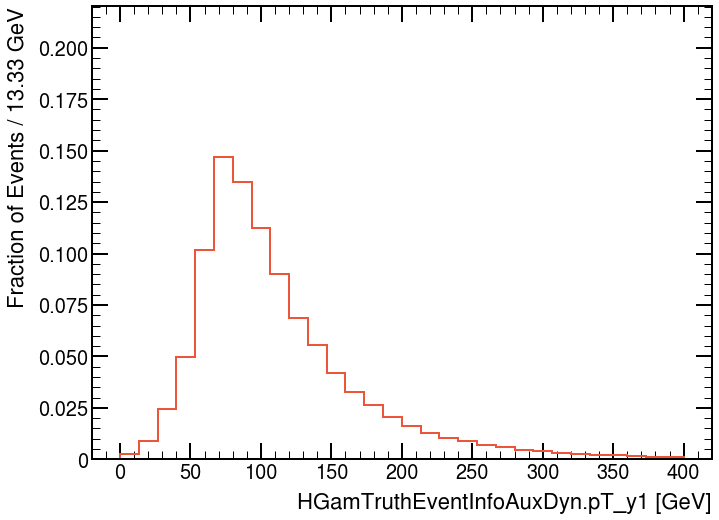

In [11]:
# can use plotter function to make plots
plotter.draw('HGamTruthEventInfoAuxDyn.pT_y1', variable_scale=1/1000,bins=30,bin_range=(0, 400),
             normalize=True,
             xlabel="HGamTruthEventInfoAuxDyn.pT_y1", unit="GeV")

In [12]:
#can apply cuts,for example at least 1 lepton and myy >106 GeV
df_lep=df[(df['HGamEventInfoAuxDyn.N_lep']>0)*(df['HGamEventInfoAuxDyn.m_yy']>106000)]

<Axes: xlabel='HGamTruthEventInfoAuxDyn.pT_y1 [GeV]', ylabel='Fraction of Events / 13.33 GeV'>

<Figure size 432x288 with 0 Axes>

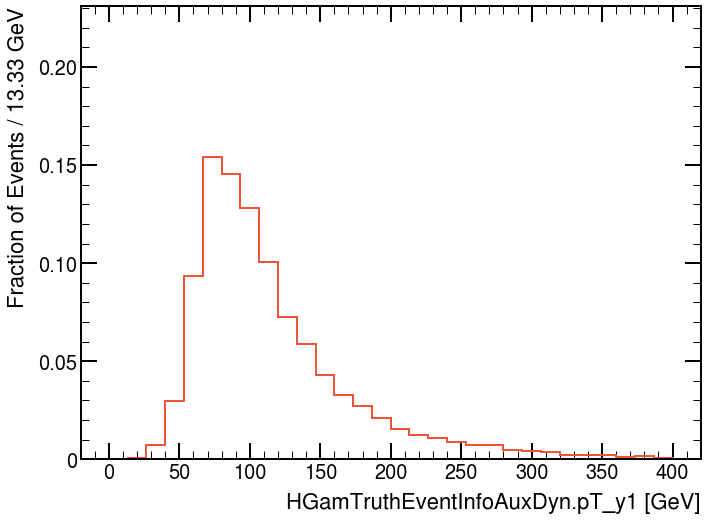

In [13]:
#pt distribution with cuts 
plotter = VariableDistributionPlot(df_lep)
plotter.draw('HGamTruthEventInfoAuxDyn.pT_y1', variable_scale=1/1000,bins=30,bin_range=(0, 400),
             normalize=True,
             xlabel="HGamTruthEventInfoAuxDyn.pT_y1", unit="GeV")

In [14]:
# using matplotlib to make plots instead
import matplotlib.pyplot as plt

In [15]:
#apply cuts at least 2 truth photons
df_2y=df[df['HGamTruthPhotonsAuxDyn.truthOrigin'].apply(len) > 1]

#2 photons coming from higgs decay truth origin def:https://gitlab.cern.ch/atlas/athena/blob/21.2/PhysicsAnalysis/MCTruthClassifier/MCTruthClassifier/MCTruthClassifierDefs.h
df_2y_H = df_2y[df_2y['HGamTruthPhotonsAuxDyn.truthOrigin'].apply(lambda x: np.count_nonzero(x == 14) == 2)]

# for vectorized branches can flatten for plotting
flattened_data = [item for sublist in df_2y_H['HGamTruthPhotonsAuxDyn.truthOrigin'] for item in sublist]

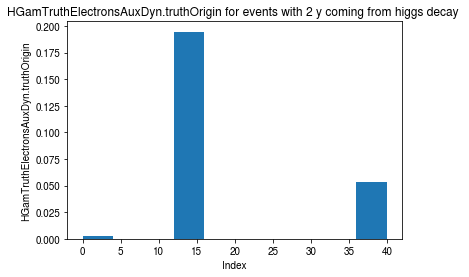

In [16]:
# Plot the data
plt.hist(flattened_data, density=True)
plt.xlabel('Index')
plt.ylabel('HGamTruthElectronsAuxDyn.truthOrigin')
plt.title('HGamTruthElectronsAuxDyn.truthOrigin for events with 2 y coming from higgs decay ')
plt.show()

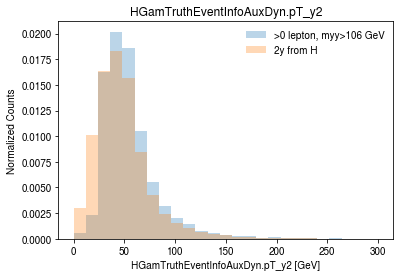

In [17]:
#compare distributions, could also look into bbyy tutorial plotter function has comparison functionality 

plt.hist(df_lep['HGamTruthEventInfoAuxDyn.pT_y2']/1000, density=True,alpha=0.3,bins=25, range=(0,300),label='>0 lepton, myy>106 GeV')
plt.hist(df_2y_H['HGamTruthEventInfoAuxDyn.pT_y2']/1000, density=True,alpha=0.3,bins=25, range=(0,300),label='2y from H')
plt.legend()
plt.ylabel('Normalized Counts')
plt.xlabel('HGamTruthEventInfoAuxDyn.pT_y2 [GeV]')
plt.title('HGamTruthEventInfoAuxDyn.pT_y2')
plt.show()

# Tasks

## Higgs $p_T$, $\eta$, $\phi$, and mass distributions

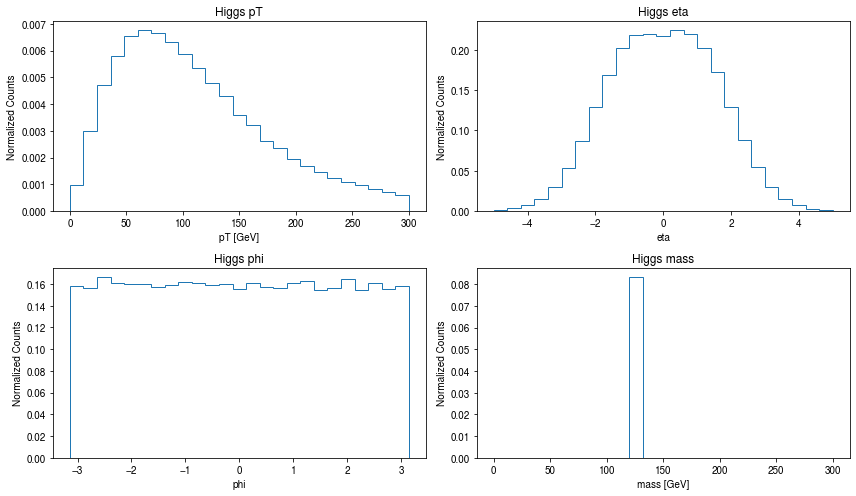

In [18]:
columns_H = ['HGamTruthHiggsBosonsAuxDyn.pt','HGamTruthHiggsBosonsAuxDyn.m','HGamTruthHiggsBosonsAuxDyn.px','HGamTruthHiggsBosonsAuxDyn.py','HGamTruthHiggsBosonsAuxDyn.pz']
array_H = root2array(filename, treename=treename, columns=columns_H, library='uproot')
df_H = pd.DataFrame(array_H)

df_H['HGamTruthHiggsBosonsAuxDyn.pt'] = df_H['HGamTruthHiggsBosonsAuxDyn.pt'].apply(lambda x: x[0])
df_H['HGamTruthHiggsBosonsAuxDyn.px'] = df_H['HGamTruthHiggsBosonsAuxDyn.px'].apply(lambda x: x[0])
df_H['HGamTruthHiggsBosonsAuxDyn.py'] = df_H['HGamTruthHiggsBosonsAuxDyn.py'].apply(lambda x: x[0])
df_H['HGamTruthHiggsBosonsAuxDyn.pz'] = df_H['HGamTruthHiggsBosonsAuxDyn.pz'].apply(lambda x: x[0])
df_H['HGamTruthHiggsBosonsAuxDyn.m'] = df_H['HGamTruthHiggsBosonsAuxDyn.m'].apply(lambda x: x[0])

pt = df_H['HGamTruthHiggsBosonsAuxDyn.pt']
px = df_H['HGamTruthHiggsBosonsAuxDyn.px']
py = df_H['HGamTruthHiggsBosonsAuxDyn.py']
pz = df_H['HGamTruthHiggsBosonsAuxDyn.pz']

# Calculate eta and phi
eta = [np.arcsinh(pz_i / pt_i) for pz_i, pt_i in zip(pz, pt)]
df_H['eta'] = eta

phi = [np.arctan2(py_i, px_i) for py_i, px_i in zip(py, px)]
df_H['phi'] = phi

# Remove invalid values
df_H = df_H[np.isfinite(df_H['eta'])]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# pT
axs[0, 0].hist(df_H['HGamTruthHiggsBosonsAuxDyn.pt']/1000, bins=25, range=(0, 300), density=True, histtype='step')
axs[0, 0].set_title('Higgs pT')
axs[0, 0].set_xlabel('pT [GeV]')
axs[0, 0].set_ylabel('Normalized Counts')

# eta
axs[0, 1].hist(df_H['eta'], bins=25, range=(-5, 5), density=True, histtype='step')
axs[0, 1].set_title('Higgs eta')
axs[0, 1].set_xlabel('eta')
axs[0, 1].set_ylabel('Normalized Counts')

# phi
axs[1, 0].hist(df_H['phi'], bins=25, range=(-np.pi, np.pi), density=True, histtype='step')
axs[1, 0].set_title('Higgs phi')
axs[1, 0].set_xlabel('phi')
axs[1, 0].set_ylabel('Normalized Counts')

# mass
axs[1, 1].hist(df_H['HGamTruthHiggsBosonsAuxDyn.m']/1000, bins=25, range=(0, 300), density=True, histtype='step')
axs[1, 1].set_title('Higgs mass')
axs[1, 1].set_xlabel('mass [GeV]')
axs[1, 1].set_ylabel('Normalized Counts')

plt.tight_layout()
# plt.savefig('HiggsKinematic.png', dpi=300)
plt.show()

## $p_T$, $\eta$, and $\phi$ distributions of the jets and b-jets in the event

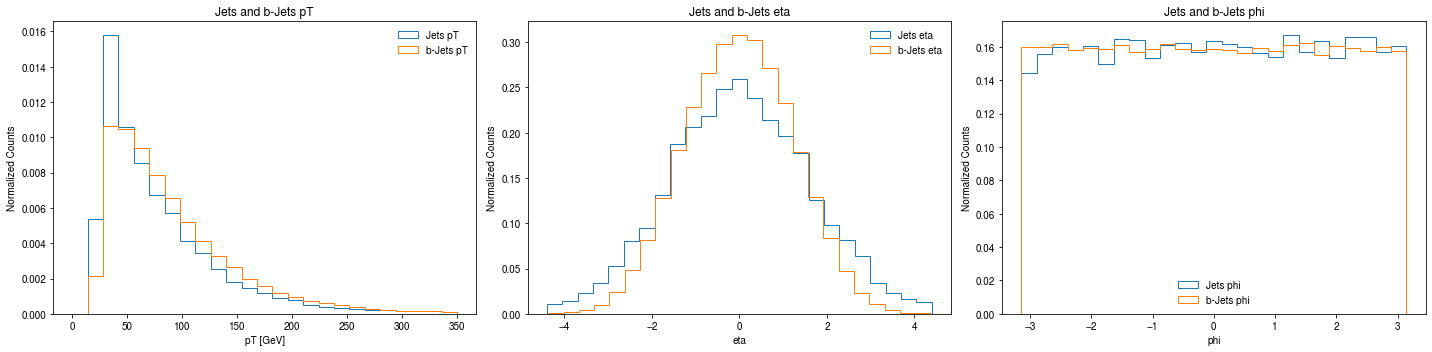

In [19]:
columns_J = ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.HadronConeExclTruthLabelID']
array_J = root2array(filename, treename=treename, columns=columns_J, library='uproot')
df_J = pd.DataFrame(array_J)

# Flatten and drop NaN
df_J = df_J.apply(pd.Series.explode)
df_J = df_J.dropna()

# Identify b-jets
def is_b_jet(label):
    return label == 5

df_bJ = df_J[df_J['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.HadronConeExclTruthLabelID'].apply(is_b_jet)]
df_J = df_J[~df_J.index.isin(df_bJ.index)]

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].hist(df_J['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'] / 1000, bins=25, density=True, range=(0,350), label='Jets pT', histtype='step')
axs[0].hist(df_bJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'] / 1000, bins=25, density=True, range=(0,350), label='b-Jets pT', histtype='step')
axs[0].set_title('Jets and b-Jets pT')
axs[0].set_xlabel('pT [GeV]')
axs[0].set_ylabel('Normalized Counts')
axs[0].legend()

axs[1].hist(df_J['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], bins=25, density=True, label='Jets eta', histtype='step')
axs[1].hist(df_bJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], bins=25, density=True, label='b-Jets eta', histtype='step')
axs[1].set_title('Jets and b-Jets eta')
axs[1].set_xlabel('eta')
axs[1].set_ylabel('Normalized Counts')
axs[1].legend()

axs[2].hist(df_J['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], bins=25, density=True, label='Jets phi', histtype='step')
axs[2].hist(df_bJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], bins=25, density=True, label='b-Jets phi', histtype='step')
axs[2].set_title('Jets and b-Jets phi')
axs[2].set_xlabel('phi')
axs[2].set_ylabel('Normalized Counts')
axs[2].legend()

plt.tight_layout()
# plt.savefig('JetsBJets.png', dpi=300)
plt.show()

## Diphoton invariant mass at reconstruction level
The invariant mass of the two photons is given by
$$m_{\gamma \gamma}=\sqrt{2E_1E_2(1-\cos\alpha)},$$
where $E_1$ and $E_2$ are the energies of the leading and subleading photons and $\alpha$ is the opening angle of the two photons with respect to their production vertex.

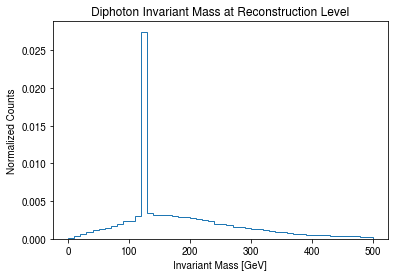

In [20]:
columns_P = ['HGamPhotonsAuxDyn.phi','HGamPhotonsAuxDyn.eta','HGamPhotonsAuxDyn.pt']
array_P = root2array(filename, treename=treename, columns=columns_P, library='uproot')
df_P = pd.DataFrame(array_P)

# Flatten and drop NaN
df_P = df_P.apply(pd.Series.explode)
df_P = df_P.dropna()

df_P['event'] = df_P.index // 2

grouped = df_P.groupby('event')

diphoton_events = []

for _, group in grouped:
    if len(group) < 2:
        continue
    group = group.sort_values(by='HGamPhotonsAuxDyn.pt', ascending=False)
    diphoton_events.append((group.iloc[0], group.iloc[1]))
    
import vector

def calculate_momentum_energy(row):
    vec = vector.obj(
        pt=row['HGamPhotonsAuxDyn.pt'],
        phi=row['HGamPhotonsAuxDyn.phi'],
        eta=row['HGamPhotonsAuxDyn.eta'],
        mass=0.0
    )
    return vec

diphoton_masses = []

for photon1, photon2 in diphoton_events:
    vec1 = calculate_momentum_energy(photon1)
    vec2 = calculate_momentum_energy(photon2)
    
    diphoton_mass = (vec1 + vec2).mass
    diphoton_masses.append(diphoton_mass / 1000)

plt.hist(diphoton_masses, bins=50, density=True, histtype='step', range=(0,500))
plt.title('Diphoton Invariant Mass at Reconstruction Level')
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Normalized Counts')
# plt.savefig('DiphotonM', dpi=300)
plt.show()

Use diphoton to reconstruct Higgs $p_T$ and $\eta$

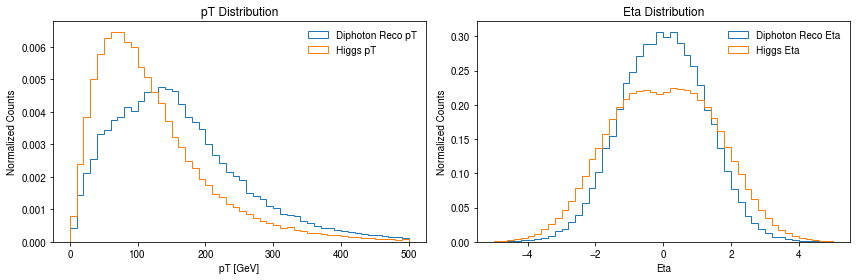

In [21]:
diphoton_pt = []
diphoton_eta = []

for photon1, photon2 in diphoton_events:
    vec1 = calculate_momentum_energy(photon1)
    vec2 = calculate_momentum_energy(photon2)
    
    combined_vec = vec1 + vec2

    reco_pt = combined_vec.pt
    reco_eta = combined_vec.eta
    
    diphoton_pt.append(reco_pt / 1000)
    diphoton_eta.append(reco_eta)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(diphoton_pt, bins=50, range=(0, 500), density=True, label='Diphoton Reco pT', histtype='step')
axs[0].hist(df_H['HGamTruthHiggsBosonsAuxDyn.pt']/1000, bins=50, range=(0, 500), density=True, label='Higgs pT', histtype='step')
axs[0].set_title('pT Distribution')
axs[0].set_xlabel('pT [GeV]')
axs[0].set_ylabel('Normalized Counts')
axs[0].legend()

axs[1].hist(diphoton_eta, bins=50, range=(-5, 5), density=True, label='Diphoton Reco Eta', histtype='step')
axs[1].hist(df_H['eta'], bins=50, range=(-5, 5), density=True, label='Higgs Eta', histtype='step')
axs[1].set_title('Eta Distribution')
axs[1].set_xlabel('Eta')
axs[1].set_ylabel('Normalized Counts')
axs[1].legend()

plt.tight_layout()
# plt.savefig('RecoTruthHiggs', dpi=300)
plt.show()

## Number of jets in the event at detector level

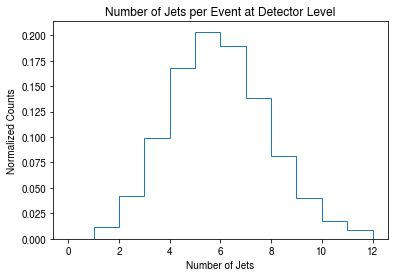

In [22]:
columns_D = ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt']
array_D = root2array(filename, treename=treename, columns=columns_D, library='uproot')
df_D = pd.DataFrame(array_D)

df_D = df_D.apply(pd.Series.explode)
df_D = df_D.dropna()

# Count the number of jets in each event
jet_counts = df_D.groupby(df_D.index).size()

plt.hist(jet_counts, bins=12, density=True, range=(0,12), histtype='step')
plt.title('Number of Jets per Event at Detector Level')
plt.xlabel('Number of Jets')
plt.ylabel('Normalized Counts')
# plt.savefig('JetsNumber.png', dpi=300)
plt.show()

## Jet triplet candidates for top decays at truth level
Achieved by selecting the truth jets following the $\chi^2$ implementation described in [this paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.116019).

In [23]:
# Branches: Truth jet quantities + Truth Higgs boson quantities
columns_tJ = ['HGamEventInfoAuxDyn.isPassed','HGamEventInfoAuxDyn.weight','HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID', 'HGamAntiKt4TruthWZJetsAuxDyn.m', 'HGamAntiKt4TruthWZJetsAuxDyn.pt','HGamAntiKt4TruthWZJetsAuxDyn.eta','HGamAntiKt4TruthWZJetsAuxDyn.phi','HGamTruthHiggsBosonsAuxDyn.m','HGamTruthHiggsBosonsAuxDyn.pt','HGamTruthHiggsBosonsAuxDyn.px','HGamTruthHiggsBosonsAuxDyn.py','HGamTruthHiggsBosonsAuxDyn.pz']
array_tJ = root2array(filename, treename=treename, columns=columns_tJ, library='uproot')
df_tJ = pd.DataFrame(array_tJ)

df_tJ['event'] = df_tJ.index

df_tJ = df_tJ.apply(pd.Series.explode)
df_tJ = df_tJ.dropna()

df_tJ = df_tJ[df_tJ['HGamEventInfoAuxDyn.isPassed'] == 1]

df_tJ = df_tJ.reset_index(drop=True)
df_tJ['jet_index'] = df_tJ.groupby('event').cumcount()

def calculate_invariant_mass(px, py, pz, energy):
    mass2 = energy**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(mass2) if mass2 >= 0 else 0

def calculate_kinematics(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return px, py, pz, energy

def chi2(top_mass, W_mass, top_width, W_width, bjet, wjets):
    b_px, b_py, b_pz, b_energy = calculate_kinematics(bjet.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.pt'], bjet.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.eta'], bjet.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.phi'], bjet.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    w1_px, w1_py, w1_pz, w1_energy = calculate_kinematics(wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.pt'], wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.eta'], wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.phi'], wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    w2_px, w2_py, w2_pz, w2_energy = calculate_kinematics(wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.pt'], wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.eta'], wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.phi'], wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    # m_{bq_1q_2}
    total_px = b_px + w1_px + w2_px
    total_py = b_py + w1_py + w2_py
    total_pz = b_pz + w1_pz + w2_pz
    total_energy = b_energy + w1_energy + w2_energy
    top_mass_calculated = calculate_invariant_mass(total_px, total_py, total_pz, total_energy)
    # m_{q_1q_2}
    w_mass_calculated = calculate_invariant_mass(w1_px + w2_px, w1_py + w2_py, w1_pz + w2_pz, w1_energy + w2_energy)
    # chi2
    chi2_top = ((top_mass_calculated - top_mass) / top_width) ** 2
    chi2_W = ((w_mass_calculated - W_mass) / W_width) ** 2
    return chi2_top + chi2_W

top_mass = 169800
W_mass = 81000
top_width = 29000
W_width = 18500

best_triplets = []

from itertools import combinations

def generate_wjet_pairs(wjets_indices):
    pairs = []
    for i in range(3):
        for j in range(i + 1, 4):
            w_pair1 = (wjets_indices[i], wjets_indices[j])
            remaining_indices = [index for index in wjets_indices if index not in w_pair1]
            if len(remaining_indices) == 2:
                w_pair2 = (remaining_indices[0], remaining_indices[1])
                pairs.append((w_pair1, w_pair2))
    return pairs

from itertools import combinations

for event_id, group in df_tJ.groupby('event'):
    bjets = group[group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] == 5]
    wjets = group[(group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] != 5) & (group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] != 0)]
    
    if len(bjets) < 2 or len(wjets) < 4:
        continue
    
    jet_triplets = []
    
    bjet_combinations = combinations(bjets.index, 2)
    wjet_combinations = combinations(wjets.index, 4)

    for bjet_pair_indices in bjet_combinations:
        bjet_pair = bjets.loc[list(bjet_pair_indices)]
        
        for wjet_quad_indices in wjet_combinations:
            wjet_quad = wjets.loc[list(wjet_quad_indices)]
            wjet_pairs = generate_wjet_pairs(wjet_quad.index)
            
            for w_pair1, w_pair2 in wjet_pairs:
                wjet_pair1 = wjets.loc[list(w_pair1)].reset_index(drop=True)
                wjet_pair2 = wjets.loc[list(w_pair2)].reset_index(drop=True)
                
                # Store two triplets: (bjet1, w_pair1) and (bjet2, w_pair2)
                triplet1 = pd.concat([bjet_pair.iloc[[0]], wjet_pair1]).reset_index(drop=True)
                triplet2 = pd.concat([bjet_pair.iloc[[1]], wjet_pair2]).reset_index(drop=True)

                chi2_value1 = chi2(top_mass, W_mass, top_width, W_width, triplet1.iloc[[0]], triplet1.iloc[1:])
                chi2_value2 = chi2(top_mass, W_mass, top_width, W_width, triplet2.iloc[[0]], triplet2.iloc[1:])

                jet_triplets.append((chi2_value1, triplet1))
                jet_triplets.append((chi2_value2, triplet2))

    # Check if find the valid combination
    if jet_triplets:
        jet_triplets = sorted(jet_triplets, key=lambda x: x[0])
        best_triplets.append(jet_triplets[0])
        best_triplets.append(jet_triplets[1])

The plot of invariant mass of the jet triplets:

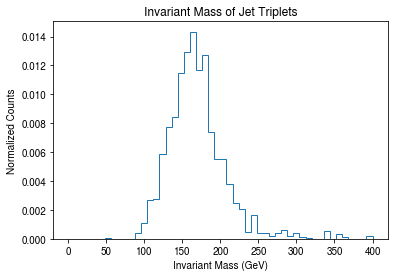

In [24]:
triplet_masses = []
triplet_weights = []
for chi2_value, triplet in best_triplets:
    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    weight = None
    
    for _, jet in triplet.iterrows():
        px, py, pz, energy = calculate_kinematics(jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'], jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'], jet['HGamAntiKt4TruthWZJetsAuxDyn.phi'], jet['HGamAntiKt4TruthWZJetsAuxDyn.m'])
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy
        
        if weight is None:
            weight = jet['HGamEventInfoAuxDyn.weight']
    
    triplet_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    triplet_masses.append(triplet_mass / 1000)
    triplet_weights.append(weight)

plt.hist(triplet_masses, bins=50, density=True, histtype='step', range=(0,400), weights=triplet_weights)
plt.title('Invariant Mass of Jet Triplets')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
# plt.savefig('JetTripletsM.png', dpi=300)
plt.show()

The plot of invariant mass of the reconstructed $t\bar{t}$ and $t\bar{t}H$ system:

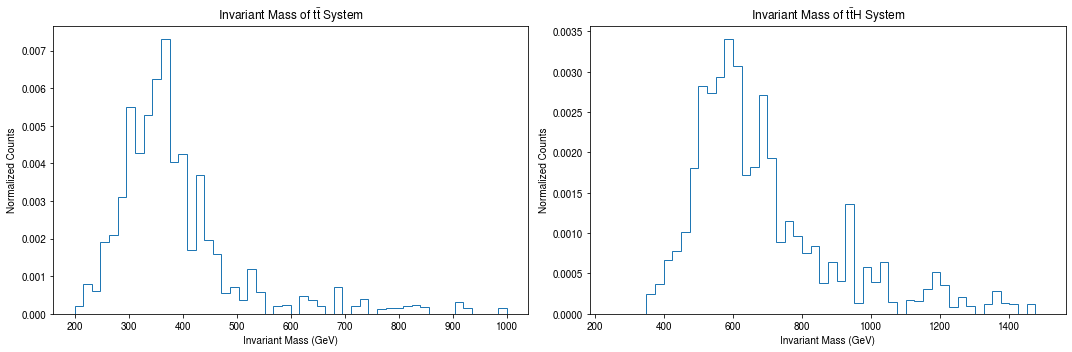

In [25]:
ttbar_masses = []
ttbar_weights = []
ttbarH_masses = []
ttbarH_weights = []

for i in range(0, len(best_triplets), 2):
    # 2 neighbour triplets
    triplet1 = best_triplets[i][1]
    triplet2 = best_triplets[i + 1][1]
    
    # Get event ID
    event_id = triplet1['event'].iloc[0]
    
    # Find the corresponding Higgs
    higgs_data = df_tJ[df_tJ['event'] == event_id].iloc[0]
    higgs_px = higgs_data['HGamTruthHiggsBosonsAuxDyn.px']
    higgs_py = higgs_data['HGamTruthHiggsBosonsAuxDyn.py']
    higgs_pz = higgs_data['HGamTruthHiggsBosonsAuxDyn.pz']
    higgs_mass = higgs_data['HGamTruthHiggsBosonsAuxDyn.m']
    higgs_energy = np.sqrt(higgs_px**2 + higgs_py**2 + higgs_pz**2 + higgs_mass**2)
    
    event_weight = df_tJ[df_tJ['event'] == event_id]['HGamEventInfoAuxDyn.weight'].iloc[0]

    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    
    for _, jet in triplet1.iterrows():
        px, py, pz, energy = calculate_kinematics(jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'],jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'],jet['HGamAntiKt4TruthWZJetsAuxDyn.phi'],jet['HGamAntiKt4TruthWZJetsAuxDyn.m'])
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy
    
    for _, jet in triplet2.iterrows():
        px, py, pz, energy = calculate_kinematics(jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'],jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'],jet['HGamAntiKt4TruthWZJetsAuxDyn.phi'],jet['HGamAntiKt4TruthWZJetsAuxDyn.m'])
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy
    
    ttbar_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    ttbar_masses.append(ttbar_mass / 1000)
    ttbar_weights.append(event_weight)
    
    px_tot += higgs_px
    py_tot += higgs_py
    pz_tot += higgs_pz
    E_tot += higgs_energy
    
    ttbarH_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    ttbarH_masses.append(ttbarH_mass / 1000)
    ttbarH_weights.append(event_weight)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(ttbar_masses, bins=50, density=True, histtype='step', range=(200,1000), weights=ttbar_weights)
axes[0].set_title('Invariant Mass of $t\\bar{t}$ System')
axes[0].set_xlabel('Invariant Mass (GeV)')
axes[0].set_ylabel('Normalized Counts')

axes[1].hist(ttbarH_masses, bins=50, density=True, histtype='step', range=(250,1500), weights=ttbarH_weights)
axes[1].set_title('Invariant Mass of $t\\bar{t}H$ System')
axes[1].set_xlabel('Invariant Mass (GeV)')
axes[1].set_ylabel('Normalized Counts')

plt.tight_layout()
# plt.savefig('ttttHM.png', dpi=300)
plt.show()

The plot of $p_T$ and $\eta$ of the above top quarks, $t\bar{t}$ system, and $t\bar{t}H$ system:

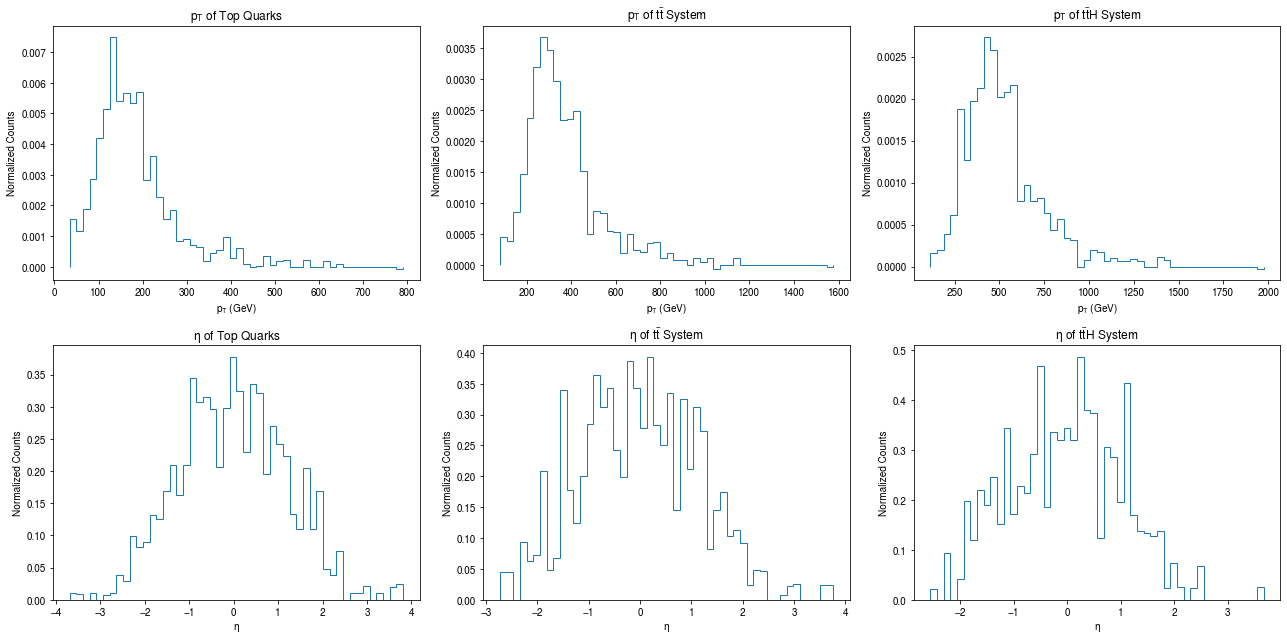

In [26]:
top_pt_list = []
top_eta_list = []
ttbar_pt_list = []
ttbar_eta_list = []
ttbarH_pt_list = []
ttbarH_eta_list = []

top_weights = []
ttbar_weights = []
ttbarH_weights = []

for i in range(0, len(best_triplets), 2):
    triplet1 = best_triplets[i][1]
    triplet2 = best_triplets[i + 1][1]

    event_id = triplet1['event'].iloc[0]
    
    event_weight = df_tJ[df_tJ['event'] == event_id]['HGamEventInfoAuxDyn.weight'].iloc[0]

    for triplet in [triplet1, triplet2]:
        pt_tot = triplet['HGamAntiKt4TruthWZJetsAuxDyn.pt'].sum()
        pz_tot = 0
        
        for _, jet in triplet.iterrows():
            pz = jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'] * np.sinh(jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'])
            pz_tot += pz
        
        top_pt_list.append(pt_tot / 1000)
        top_eta_list.append(np.arcsinh(pz_tot / pt_tot))
        top_weights.append(event_weight)

    ttbar_pt = triplet1['HGamAntiKt4TruthWZJetsAuxDyn.pt'].sum() + triplet2['HGamAntiKt4TruthWZJetsAuxDyn.pt'].sum()
    ttbar_pz = 0

    for triplet in [triplet1, triplet2]:
        for _, jet in triplet.iterrows():
            pz = jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'] * np.sinh(jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'])
            ttbar_pz += pz
    
    ttbar_pt_list.append(ttbar_pt / 1000)
    ttbar_eta_list.append(np.arcsinh(ttbar_pz / ttbar_pt))
    ttbar_weights.append(event_weight)

    higgs_data = df_tJ[df_tJ['event'] == event_id].iloc[0]
    higgs_pz = higgs_data['HGamTruthHiggsBosonsAuxDyn.pz']
    higgs_pt = higgs_data['HGamTruthHiggsBosonsAuxDyn.pt']

    ttbarH_pt = ttbar_pt + higgs_pt
    ttbarH_pz = ttbar_pz + higgs_pz

    ttbarH_pt_list.append(ttbarH_pt / 1000)
    ttbarH_eta_list.append(np.arcsinh(ttbarH_pz / ttbarH_pt))
    ttbarH_weights.append(event_weight)

fig, axes = plt.subplots(2, 3, figsize=(18, 9))

# Plot pT
axes[0, 0].hist(top_pt_list, bins=50, density=True, histtype='step', weights=top_weights)
axes[0, 0].set_title('$p_T$ of Top Quarks')
axes[0, 0].set_xlabel('$p_T$ (GeV)')
axes[0, 0].set_ylabel('Normalized Counts')

axes[0, 1].hist(ttbar_pt_list, bins=50, density=True, histtype='step', weights=ttbar_weights)
axes[0, 1].set_title('$p_T$ of $t\\bar{t}$ System')
axes[0, 1].set_xlabel('$p_T$ (GeV)')
axes[0, 1].set_ylabel('Normalized Counts')

axes[0, 2].hist(ttbarH_pt_list, bins=50, density=True, histtype='step', weights=ttbarH_weights)
axes[0, 2].set_title('$p_T$ of $t\\bar{t}H$ System')
axes[0, 2].set_xlabel('$p_T$ (GeV)')
axes[0, 2].set_ylabel('Normalized Counts')

# Plot eta
axes[1, 0].hist(top_eta_list, bins=50, density=True, histtype='step', weights=top_weights)
axes[1, 0].set_title('$\\eta$ of Top Quarks')
axes[1, 0].set_xlabel('$\\eta$')
axes[1, 0].set_ylabel('Normalized Counts')

axes[1, 1].hist(ttbar_eta_list, bins=50, density=True, histtype='step', weights=ttbar_weights)
axes[1, 1].set_title('$\\eta$ of $t\\bar{t}$ System')
axes[1, 1].set_xlabel('$\\eta$')
axes[1, 1].set_ylabel('Normalized Counts')

axes[1, 2].hist(ttbarH_eta_list, bins=50, density=True, histtype='step', weights=ttbarH_weights)
axes[1, 2].set_title('$\\eta$ of $t\\bar{t}H$ System')
axes[1, 2].set_xlabel('$\\eta$')
axes[1, 2].set_ylabel('Normalized Counts')

plt.tight_layout()
# plt.savefig('ptEtaAll.png', dpi=300)
plt.show()

The median and one half the inter-quantile range between 15.9 and 84.1 percentile of the above three invariant masses as a function of the number of truth.

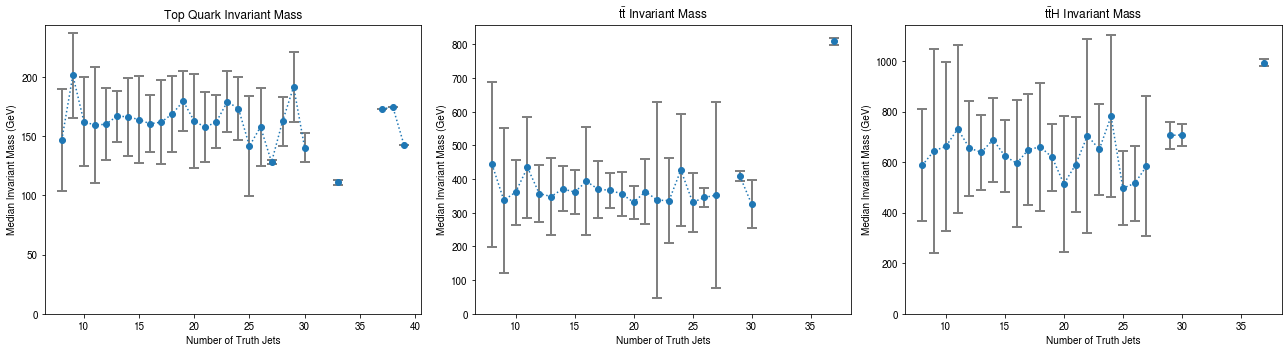

In [27]:
df_jet_counts = df_tJ.groupby('event').size().reset_index(name='jet_count')

jet_counts = []
weights = []
for chi2_value, triplet in best_triplets:
    event_id = triplet['event'].iloc[0]
    jet_count = df_jet_counts[df_jet_counts['event'] == event_id]['jet_count'].values[0]
    jet_counts.append(jet_count)
    
    event_weight = df_tJ[df_tJ['event'] == event_id]['HGamEventInfoAuxDyn.weight'].iloc[0]
    weights.append(event_weight)

mass_stats = {
    'jet_count': [],
    'triplet_median': [],
    'triplet_iqr': [],
    'ttbar_median': [],
    'ttbar_iqr': [],
    'ttbarH_median': [],
    'ttbarH_iqr': []
}

def weighted_median(data, weights):
    sorted_data, sorted_weights = zip(*sorted(zip(data, weights)))
    cumulative_weight = np.cumsum(sorted_weights)
    cutoff = cumulative_weight[-1] / 2.0
    return sorted_data[np.searchsorted(cumulative_weight, cutoff)]

def weighted_percentile(data, weights, percentile):
    sorted_data, sorted_weights = zip(*sorted(zip(data, weights)))
    cumulative_weight = np.cumsum(sorted_weights)
    cutoff = percentile / 100.0 * cumulative_weight[-1]
    return sorted_data[np.searchsorted(cumulative_weight, cutoff)]

unique_jet_counts = sorted(df_jet_counts['jet_count'].unique())
for count in unique_jet_counts:
    triplet_masses_for_count = [mass for mass, jets in zip(triplet_masses, jet_counts) if jets == count]
    ttbar_masses_for_count = [mass for mass, jets in zip(ttbar_masses, jet_counts) if jets == count]
    ttbarH_masses_for_count = [mass for mass, jets in zip(ttbarH_masses, jet_counts) if jets == count]
    weights_for_count = [w for jets, w in zip(jet_counts, weights) if jets == count]
    
    mass_stats['jet_count'].append(count)
    
    if triplet_masses_for_count:
        mass_stats['triplet_median'].append(weighted_median(triplet_masses_for_count, weights_for_count))
        mass_stats['triplet_iqr'].append((weighted_percentile(triplet_masses_for_count, weights_for_count, 84.1) - weighted_percentile(triplet_masses_for_count, weights_for_count, 15.9)) / 2)
    else:
        mass_stats['triplet_median'].append(np.nan)
        mass_stats['triplet_iqr'].append(np.nan)
    
    if ttbar_masses_for_count:
        mass_stats['ttbar_median'].append(weighted_median(ttbar_masses_for_count, weights_for_count))
        mass_stats['ttbar_iqr'].append((weighted_percentile(ttbar_masses_for_count, weights_for_count, 84.1) - weighted_percentile(ttbar_masses_for_count, weights_for_count, 15.9)) / 2)
    else:
        mass_stats['ttbar_median'].append(np.nan)
        mass_stats['ttbar_iqr'].append(np.nan)
        
    if ttbarH_masses_for_count:
        mass_stats['ttbarH_median'].append(weighted_median(ttbarH_masses_for_count, weights_for_count))
        mass_stats['ttbarH_iqr'].append((weighted_percentile(ttbarH_masses_for_count, weights_for_count, 84.1) - weighted_percentile(ttbarH_masses_for_count, weights_for_count, 15.9)) / 2)
    else:
        mass_stats['ttbarH_median'].append(np.nan)
        mass_stats['ttbarH_iqr'].append(np.nan)

mass_stats_df = pd.DataFrame(mass_stats)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].errorbar(mass_stats_df['jet_count'], mass_stats_df['triplet_median'], yerr=mass_stats_df['triplet_iqr'], fmt='o:', ecolor='gray', capsize=5, capthick=2, elinewidth=2)
ax[0].set_title('Top Quark Invariant Mass')
ax[0].set_xlabel('Number of Truth Jets')
ax[0].set_ylabel('Median Invariant Mass (GeV)')
ax[0].set_ylim(0, None)

ax[1].errorbar(mass_stats_df['jet_count'], mass_stats_df['ttbar_median'], yerr=mass_stats_df['ttbar_iqr'], fmt='o:', ecolor='gray', capsize=5, capthick=2, elinewidth=2)
ax[1].set_title('$t\\bar{t}$ Invariant Mass')
ax[1].set_xlabel('Number of Truth Jets')
ax[1].set_ylabel('Median Invariant Mass (GeV)')
ax[1].set_ylim(0, None)

ax[2].errorbar(mass_stats_df['jet_count'], mass_stats_df['ttbarH_median'], yerr=mass_stats_df['ttbarH_iqr'], fmt='o:', ecolor='gray', capsize=5, capthick=2, elinewidth=2)
ax[2].set_title('$t\\bar{t}H$ Invariant Mass')
ax[2].set_xlabel('Number of Truth Jets')
ax[2].set_ylabel('Median Invariant Mass (GeV)')
ax[2].set_ylim(0, None)

plt.tight_layout()
# plt.savefig('MedianInterquartile.png', dpi=300)
plt.show()

## $\chi^2$ performance evaluation

### Truth matching reconstructed jets to truth jets

In [28]:
# Branches: Reco jet quantities
columns_rJ = ['HGamEventInfoAuxDyn.isPassed','HGamEventInfoAuxDyn.weight','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.DL1r_bin','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi','HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt']
array_rJ = root2array(filename, treename=treename, columns=columns_rJ, library='uproot')
df_rJ = pd.DataFrame(array_rJ)

# Assign event numbers before exploding
df_rJ['event'] = df_rJ.index

df_rJ = df_rJ.apply(pd.Series.explode)
df_rJ = df_rJ.dropna()

df_rJ = df_rJ[df_rJ['HGamEventInfoAuxDyn.isPassed'] == 1]

df_rJ = df_rJ.reset_index(drop=True)
df_rJ['jet_index'] = df_rJ.groupby('event').cumcount()

In [29]:
def delta_R(eta1, phi1, eta2, phi2):
    eta1 = np.array(eta1)
    phi1 = np.array(phi1)
    eta2 = np.array(eta2, dtype=np.float64)
    phi2 = np.array(phi2, dtype=np.float64)

    dphi = np.abs(phi1 - phi2)
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)

matched_labels = []
matched_indices = []
for event_id, group in df_rJ.groupby('event'):
    truth_jets = df_tJ[df_tJ['event'] == event_id]
    if not truth_jets.empty:
        for index, reco_jet in group.iterrows():
            reco_eta = np.array([reco_jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta']])
            reco_phi = np.array([reco_jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi']])

            dRs = delta_R(reco_eta, reco_phi, truth_jets['HGamAntiKt4TruthWZJetsAuxDyn.eta'], truth_jets['HGamAntiKt4TruthWZJetsAuxDyn.phi'])
            min_index = np.argmin(dRs)
            matched_labels.append(truth_jets.iloc[min_index]['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'])
            matched_indices.append(truth_jets.iloc[min_index]['jet_index'])
    else:
        matched_labels.extend([np.nan] * len(group))
        matched_indices.extend([np.nan] * len(group))

df_rJ['matched_truth_label'] = matched_labels
df_rJ['matched_jet_index'] = matched_indices

Do the direct correspondence: build the best_triplets directly from "matched_jet_index"

In [30]:
matching_triplets = []

for chi2_value, truth_triplet in best_triplets:
    event_id = truth_triplet['event'].iloc[0]
    reco_jets = df_rJ[df_rJ['event'] == event_id]

    matching_reco_triplet = reco_jets[reco_jets['matched_jet_index'].isin(truth_triplet['jet_index'])]

    if len(matching_reco_triplet) == 3:
        matching_triplets.append(matching_reco_triplet)

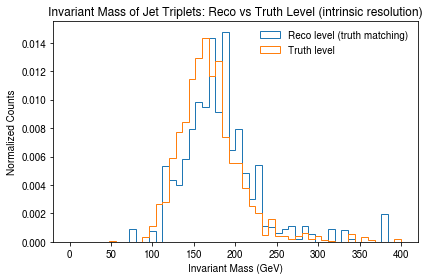

In [31]:
matchingtriplet_masses = []
matching_weights = []

for triplet in matching_triplets:  # 不再解包成 chi2_value, triplet
    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    weight = None
    
    for _, jet in triplet.iterrows():
        px, py, pz, energy = calculate_kinematics(jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m'])
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy
        
        if weight is None:
            weight = jet['HGamEventInfoAuxDyn.weight']
    
    triplet_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    matchingtriplet_masses.append(triplet_mass / 1000)
    matching_weights.append(weight)

plt.hist(matchingtriplet_masses, bins=50, density=True, label='Reco level (truth matching)', histtype='step', range=(0,400), weights=matching_weights)
plt.hist(triplet_masses, bins=50, density=True, label='Truth level', histtype='step', range=(0,400), weights=triplet_weights)
plt.title('Invariant Mass of Jet Triplets: Reco vs Truth Level (intrinsic resolution)')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.tight_layout()
# plt.savefig('IntrinsicResolution', dpi=300)
plt.show()

Do the triplet identification at Reco level: Frist truth matching, then $\chi^2$

In [32]:
def chi2_reco(top_mass, W_mass, top_width, W_width, bjet, wjets):
    b_px, b_py, b_pz, b_energy = calculate_kinematics(bjet.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'], bjet.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], bjet.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], bjet.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m'])
    w1_px, w1_py, w1_pz, w1_energy = calculate_kinematics(wjets.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'], wjets.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], wjets.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], wjets.iloc[0]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m'])
    w2_px, w2_py, w2_pz, w2_energy = calculate_kinematics(wjets.iloc[1]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'], wjets.iloc[1]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], wjets.iloc[1]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], wjets.iloc[1]['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m'])
    # m_{bq_1q_2}
    total_px = b_px + w1_px + w2_px
    total_py = b_py + w1_py + w2_py
    total_pz = b_pz + w1_pz + w2_pz
    total_energy = b_energy + w1_energy + w2_energy
    top_mass_calculated = calculate_invariant_mass(total_px, total_py, total_pz, total_energy)
    # m_{q_1q_2}
    w_mass_calculated = calculate_invariant_mass(w1_px + w2_px, w1_py + w2_py, w1_pz + w2_pz, w1_energy + w2_energy)
    # chi2
    chi2_top = ((top_mass_calculated - top_mass) / top_width) ** 2
    chi2_W = ((w_mass_calculated - W_mass) / W_width) ** 2
    return chi2_top + chi2_W

reco_triplets = []

from itertools import combinations

for event_id, group in df_rJ.groupby('event'):
    bjets = group[group['matched_truth_label'] == 5]
    wjets = group[(group['matched_truth_label'] != 5) & (group['matched_truth_label'] != 0)]
    
    if len(bjets) < 2 or len(wjets) < 4:
        continue
    
    jet_triplets = []
    
    bjet_combinations = combinations(bjets.index, 2)
    wjet_combinations = combinations(wjets.index, 4)

    for bjet_pair_indices in bjet_combinations:
        bjet_pair = bjets.loc[list(bjet_pair_indices)]
        
        for wjet_quad_indices in wjet_combinations:
            wjet_quad = wjets.loc[list(wjet_quad_indices)]
            wjet_pairs = generate_wjet_pairs(wjet_quad.index)
            
            for w_pair1, w_pair2 in wjet_pairs:
                wjet_pair1 = wjets.loc[list(w_pair1)].reset_index(drop=True)
                wjet_pair2 = wjets.loc[list(w_pair2)].reset_index(drop=True)
                
                # Store two triplets: (bjet1, w_pair1) and (bjet2, w_pair2)
                triplet1 = pd.concat([bjet_pair.iloc[[0]], wjet_pair1]).reset_index(drop=True)
                triplet2 = pd.concat([bjet_pair.iloc[[1]], wjet_pair2]).reset_index(drop=True)

                chi2_value1 = chi2_reco(top_mass, W_mass, top_width, W_width, triplet1.iloc[[0]], triplet1.iloc[1:])
                chi2_value2 = chi2_reco(top_mass, W_mass, top_width, W_width, triplet2.iloc[[0]], triplet2.iloc[1:])

                jet_triplets.append((chi2_value1, triplet1))
                jet_triplets.append((chi2_value2, triplet2))

    # Check if find the valid combination
    if jet_triplets:
        jet_triplets = sorted(jet_triplets, key=lambda x: x[0])
        reco_triplets.append(jet_triplets[0])
        reco_triplets.append(jet_triplets[1])

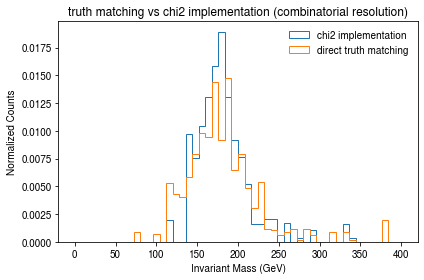

In [33]:
recotriplet_masses = []
recotriplet_weights = []

for chi2_value, triplet in reco_triplets:
    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    weight = None
    
    for _, jet in triplet.iterrows():
        px, py, pz, energy = calculate_kinematics(jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'], jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m'])
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy
        
        if weight is None:
            weight = jet['HGamEventInfoAuxDyn.weight']
    
    triplet_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    recotriplet_masses.append(triplet_mass / 1000)
    recotriplet_weights.append(weight)

plt.hist(recotriplet_masses, bins=50, density=True, label='chi2 implementation', histtype='step', range=(0,400), weights=recotriplet_weights)
plt.hist(matchingtriplet_masses, bins=50, density=True, label='direct truth matching', histtype='step', range=(0,400), weights=matching_weights)
plt.title('truth matching vs chi2 implementation (combinatorial resolution)')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.tight_layout()
# plt.savefig('CombinatorialResolution.png', dpi=300)
plt.show()